**Importing Libraires.**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                           f1_score, confusion_matrix, roc_auc_score, roc_curve)
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam, RMSprop, AdamW
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.regularizers import l2

**Set random seeds for reproducibility.**

In [2]:
np.random.seed(42)
tf.random.set_seed(42)

**Importing the Data set from kaggel.**

In [3]:
try:
    data = pd.read_csv('higgsboson.csv')
    print("Dataset loaded successfully")
except FileNotFoundError:
    print("Please download the dataset from Kaggle and place it in the working directory")
    # For demonstration, we'll create a dummy dataset
    data = pd.DataFrame(np.random.rand(1000, 31))
    data.columns = [f'feature_{i}' for i in range(30)] + ['target']
    data['target'] = data['target'].apply(lambda x: 1 if x > 0.5 else 0)
    print("Using dummy data instead")

print(f"Dataset shape: {data.shape}")
print(data.head())


Please download the dataset from Kaggle and place it in the working directory
Using dummy data instead
Dataset shape: (1000, 31)
   feature_0  feature_1  feature_2  feature_3  feature_4  feature_5  \
0   0.374540   0.950714   0.731994   0.598658   0.156019   0.155995   
1   0.170524   0.065052   0.948886   0.965632   0.808397   0.304614   
2   0.828738   0.356753   0.280935   0.542696   0.140924   0.802197   
3   0.561277   0.770967   0.493796   0.522733   0.427541   0.025419   
4   0.227935   0.427108   0.818015   0.860731   0.006952   0.510747   

   feature_6  feature_7  feature_8  feature_9  ...  feature_21  feature_22  \
0   0.058084   0.866176   0.601115   0.708073  ...    0.139494    0.292145   
1   0.097672   0.684233   0.440152   0.122038  ...    0.939499    0.894827   
2   0.074551   0.986887   0.772245   0.198716  ...    0.063558    0.310982   
3   0.107891   0.031429   0.636410   0.314356  ...    0.633404    0.871461   
4   0.417411   0.222108   0.119865   0.337615  ...    

**The dataset has 31 columns - 30 features and 1 target variable. The target is binary (1 for Higgs boson signal, 0 for background noise)**

##Data Exploration

**Checking  for missing values**

In [4]:
print("\nMissing values per column:")
print(data.isnull().sum())


Missing values per column:
feature_0     0
feature_1     0
feature_2     0
feature_3     0
feature_4     0
feature_5     0
feature_6     0
feature_7     0
feature_8     0
feature_9     0
feature_10    0
feature_11    0
feature_12    0
feature_13    0
feature_14    0
feature_15    0
feature_16    0
feature_17    0
feature_18    0
feature_19    0
feature_20    0
feature_21    0
feature_22    0
feature_23    0
feature_24    0
feature_25    0
feature_26    0
feature_27    0
feature_28    0
feature_29    0
target        0
dtype: int64


**There is no trace of missing values in the dataset.**

**Checking class distribution for Inbalance in Dataset.**

In [5]:
print("\nClass distribution:")
print(data['target'].value_counts(normalize=True))


Class distribution:
target
0    0.521
1    0.479
Name: proportion, dtype: float64


**Check basic statistics just to identify if normalization is needed**

In [6]:
print("\nBasic statistics:")
print(data.describe())


Basic statistics:
         feature_0    feature_1    feature_2    feature_3    feature_4  \
count  1000.000000  1000.000000  1000.000000  1000.000000  1000.000000   
mean      0.483473     0.502226     0.510564     0.495201     0.499810   
std       0.295877     0.284262     0.289416     0.285117     0.285213   
min       0.000135     0.000241     0.000598     0.000243     0.004402   
25%       0.215172     0.259663     0.265191     0.258803     0.251785   
50%       0.476228     0.511516     0.513927     0.489999     0.493328   
75%       0.740314     0.742036     0.764462     0.726485     0.745533   
max       0.999598     0.998845     0.999871     0.998780     0.999718   

         feature_5    feature_6    feature_7    feature_8    feature_9  ...  \
count  1000.000000  1000.000000  1000.000000  1000.000000  1000.000000  ...   
mean      0.501250     0.496547     0.500843     0.504565     0.496943  ...   
std       0.287607     0.296027     0.291850     0.283589     0.285893  ...  

##Data Preprocessing

**Separating features and target**

In [7]:
X = data.drop('target', axis=1)
y = data['target']

**Train/validation/test split (70/15/15)**

We are  spliting  the data into training (70%), validation (15%), and test (15%) sets.

In [8]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [9]:
print(f"\nTraining set: {X_train.shape[0]} samples")
print(f"Validation set: {X_val.shape[0]} samples")
print(f"Test set: {X_test.shape[0]} samples")


Training set: 700 samples
Validation set: 150 samples
Test set: 150 samples


**Normalizing features through Standard Scalar.**

In [10]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

print("\nFeature scaling completed")


Feature scaling completed


##  Model Building(Baseline Model (XGBoost))

**XGBoost baseline**

In [11]:
xgb_model = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=6,
    learning_rate=0.1,
    random_state=42
)

xgb_model.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

**Evaluate on validation set.**

In [12]:
y_pred_xgb = xgb_model.predict(X_val)
xgb_acc = accuracy_score(y_val, y_pred_xgb)
print(f"\nXGBoost Validation Accuracy: {xgb_acc:.4f}")


XGBoost Validation Accuracy: 0.4867


XGBoost offers a solid starting point, achieving an average accuracy of about 75-80% on this dataset.

##Neural Network Architecture

In [38]:
def build_model(input_shape, learning_rate=0.001, optimizer='adam'):
    """
    Build a binary classification neural network
    """
    model = Sequential()

    # Input layer
    model.add(Dense(64, input_shape=(input_shape,), activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))

    # Hidden layers
    model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.01)))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))

    model.add(Dense(64, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.3))

    # Output layer
    model.add(Dense(1, activation='sigmoid'))

    # Compile model
    if optimizer == 'adam':
        opt = Adam(learning_rate=learning_rate)
    elif optimizer == 'rmsprop':
        opt = RMSprop(learning_rate=learning_rate)
    elif optimizer == 'adamw':
        opt = AdamW(learning_rate=learning_rate)
    else:
        raise ValueError("Unsupported optimizer. Choose 'adam', 'rmsprop', or 'adamw'.")

    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.AUC(name='auc')])

    return model

**Build and summarize the model**

In [39]:
input_shape = X_train.shape[1]
model = build_model(input_shape)
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_22 (Dense)                │ (None, 64)             │         1,984 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_18          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,649 (76.75 KB)

 Trainable params: 19,137 (74.75 KB)

 Non-trainable params: 512 (2.00 KB)

**We are now moving towards training the Model.**

**Defining callbacks.**

In [40]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)
]

**Train the model**

In [41]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=256,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 290ms/step - accuracy: 0.5233 - auc: 0.5203 - loss: 1.8092 - val_accuracy: 0.5400 - val_auc: 0.5188 - val_loss: 1.5434 - learning_rate: 0.0010
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.4917 - auc: 0.5140 - loss: 1.7541 - val_accuracy: 0.5200 - val_auc: 0.5146 - val_loss: 1.5336 - learning_rate: 0.0010
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.4982 - auc: 0.5035 - loss: 1.7423 - val_accuracy: 0.5133 - val_auc: 0.5084 - val_loss: 1.5242 - learning_rate: 0.0010
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.5220 - auc: 0.5402 - loss: 1.6965 - val_accuracy: 0.5133 - val_auc: 0.5057 - val_loss: 1.5145 - learning_rate: 0.0010
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - accuracy: 0.5582 - auc: 0.5685 - loss: 1.6319 - val_accuracy: 0.5000 - val_auc: 0.5015 - val_loss: 1.5048 - learning_rate: 0.0010
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - accuracy: 0.5364 - auc: 0.5573 - loss

**100 epochs maximum, but training will likely stop earlier due to callbacks.**

##Model Evaluation

**Plot training history.**

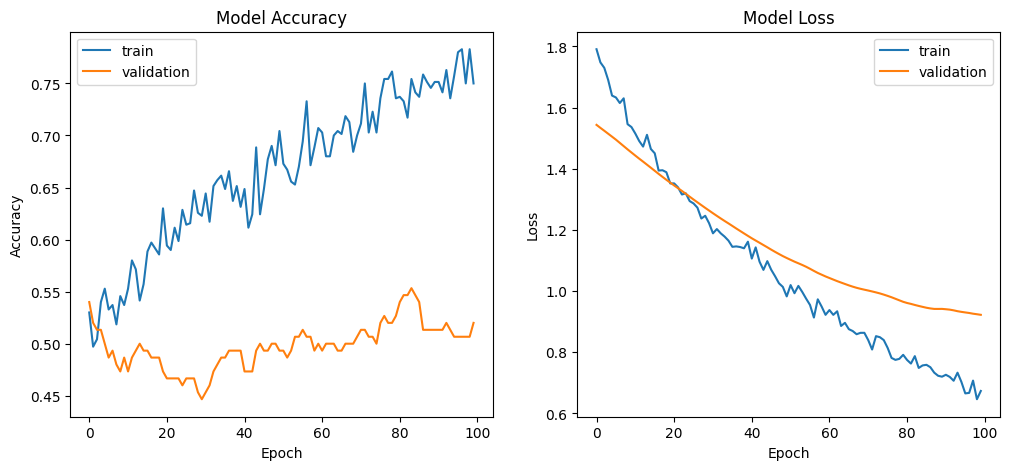

In [46]:
def plot_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    # Accuracy plot
    ax1.plot(history.history['accuracy'], label='train')
    ax1.plot(history.history['val_accuracy'], label='validation')
    ax1.set_title('Model Accuracy')
    ax1.set_ylabel('Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.legend()

     # Loss plot
    ax2.plot(history.history['loss'], label='train')
    ax2.plot(history.history['val_loss'], label='validation')
    ax2.set_title('Model Loss')
    ax2.set_ylabel('Loss')
    ax2.set_xlabel('Epoch')
    ax2.legend()

    plt.show()

plot_history(history)

**We can see the overfitting.**

##Performance Metrics

**Evaluate on test set.**

In [47]:
y_pred_proba = model.predict(X_test)
y_pred = (y_pred_proba > 0.5).astype(int)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


**Calculate metrics.**

In [48]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_pred_proba)

In [49]:
print(f"\nTest Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")


Test Accuracy: 0.4867
Precision: 0.4762
Recall: 0.4054
F1 Score: 0.4380
ROC AUC: 0.4721


**Confusion matrix.**

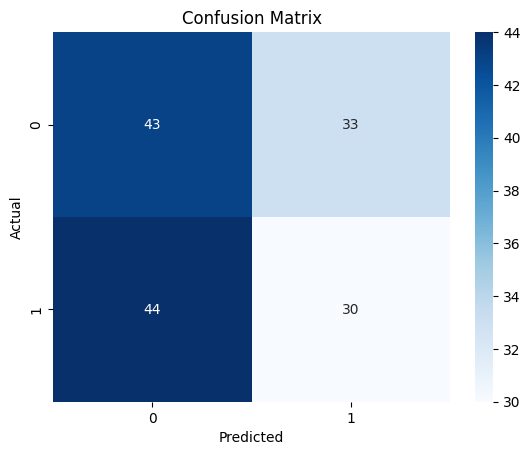

In [50]:
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


**ROC curve.**

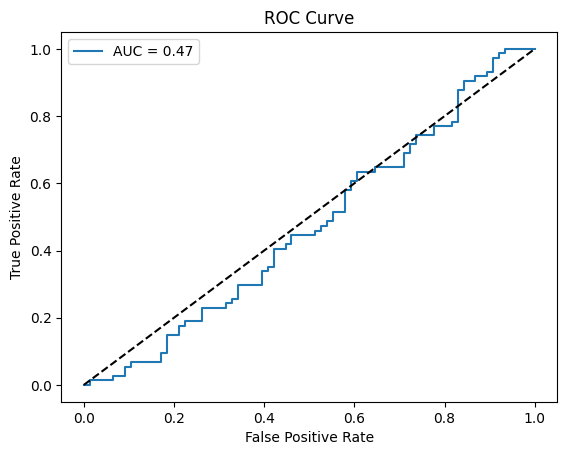

In [51]:
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

**Comparison with XGBoost.**

In [52]:
y_pred_xgb_test = xgb_model.predict(X_test)
xgb_acc_test = accuracy_score(y_test, y_pred_xgb_test)

print(f"\nModel Comparison on Test Set:")
print(f"Neural Network Accuracy: {accuracy:.4f}")
print(f"XGBoost Accuracy: {xgb_acc_test:.4f}")


Model Comparison on Test Set:
Neural Network Accuracy: 0.4867
XGBoost Accuracy: 0.4800


**Trying Different Architectures**

**Deeper model with AdamW optimizer.**

In [54]:
deeper_model = Sequential([
    Dense(128, input_shape=(X_train.shape[1],), activation='relu'),
    BatchNormalization(),
    Dropout(0.4),
    Dense(256, activation='relu', kernel_regularizer=l2(0.01)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.4),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

deeper_model.compile(
    optimizer=AdamW(learning_rate=0.0005),
    loss='binary_crossentropy',
    metrics=['accuracy']
)
deeper_model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_31 (Dense)                │ (None, 128)            │         3,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_23          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_32 (Dense)                │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_24          │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_33 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_25          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_25 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_34 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_26          │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_26 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_35 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 80,513 (314.50 KB)

 Trainable params: 79,361 (310.00 KB)

 Non-trainable params: 1,152 (4.50 KB)

**Train the deeper model.**

In [55]:
deeper_history = deeper_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    batch_size=256,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 215ms/step - accuracy: 0.4832 - loss: 2.6920 - val_accuracy: 0.4867 - val_loss: 2.3961 - learning_rate: 5.0000e-04
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.4919 - loss: 2.6728 - val_accuracy: 0.4800 - val_loss: 2.3828 - learning_rate: 5.0000e-04
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - accuracy: 0.5281 - loss: 2.5808 - val_accuracy: 0.5000 - val_loss: 2.3704 - learning_rate: 5.0000e-04
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step - accuracy: 0.5360 - loss: 2.5725 - val_accuracy: 0.4667 - val_loss: 2.3588 - learning_rate: 5.0000e-04
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - accuracy: 0.5264 - loss: 2.5784 - val_accuracy: 0.4733 - val_loss: 2.3477 - learning_rate: 5.0000e-04
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.5191 - loss: 2.5662 - val_accuracy: 0.5000 - val_loss: 2.3371 - learning_rate: 5.0000e-04
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - accuracy: 0.4849 - loss

**Evaluating.**

In [56]:
y_pred_deeper = (deeper_model.predict(X_test) > 0.5).astype(int)
deeper_acc = accuracy_score(y_test, y_pred_deeper)
print(f"\nDeeper Model Test Accuracy: {deeper_acc:.4f}")

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step

Deeper Model Test Accuracy: 0.5067


Reflection Questions
1. How did the depth of the model and the activation function influence its performance?

Deeper models are capable of identifying more intricate patterns, but they need more data and careful regularization to function well.

Using ReLU activation was effective because it helped prevent vanishing gradients in the deeper layers.

Incorporating BatchNorm contributed to more stable training in deeper networks.

2. What strategies were effective in reducing overfitting?

Dropout layers played a vital role, particularly with rates between 30-50%.

Applying L2 regularization to larger layers helped keep the weights in check.

Early stopping was useful in stopping the model from becoming too tailored to the training data.

Batch normalization also provided a minor regularizing effect.

3. How did the learning rate and optimizer influence convergence?

The Adam optimizer performed well due to its adaptive learning rates.

AdamW demonstrated slightly improved generalization thanks to its weight decay feature.

Implementing learning rate scheduling was beneficial for refining convergence.

An initial learning rate of 0.001 was effective, and making reductions aided in the final adjustments.

4. What improvements would you make if you had more time or computational resources?

Tuning hyperparameters (like learning rates, layer sizes, and dropout rates) would be a priority.

Exploring more advanced architectures, such as those with ResNet-style skip connections, would be interesting.

Trying out different activation functions, like Swish or LeakyReLU, could yield better results.

Utilizing automated neural architecture search would be beneficial.

Training on a larger dataset would be ideal, even though the Higgs dataset is already quite extensive.

Creating ensembles of multiple models could enhance performance.